In [1]:
import os
os.chdir('/home/xinglong/git_local/dynamax/')

import matplotlib.pyplot as plt

In [2]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax

from dynamax.structural_time_series.models.sts_model import StructuralTimeSeries as STS
from dynamax.structural_time_series.models.sts_components import *

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN
)

Test LocalLinearTrend forecast

2022-11-06 22:06:24.677315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-06 22:06:24.677331: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
Do not call `graph_parents`.


Instructions for updating:
Do not call `graph_parents`.
2022-11-06 22:06:28.976109: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed


Instructions for updating:
`Imputed distributions returned by`tfp.sts.impute_missing_values` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


Instructions for updating:
`Imputed distributions returned by`tfp.sts.impute_missing_values` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


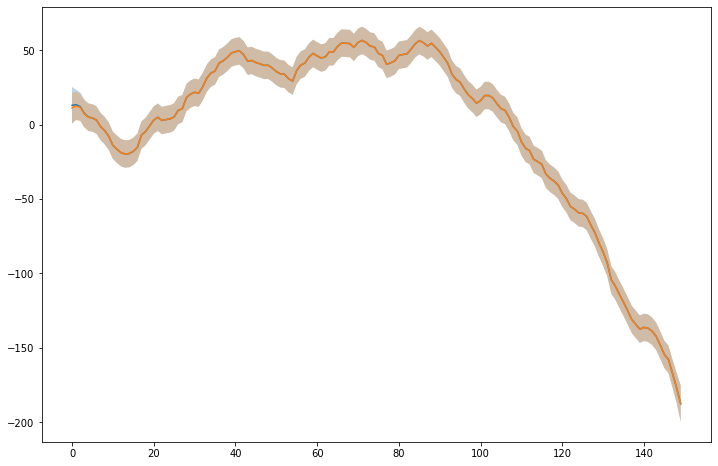

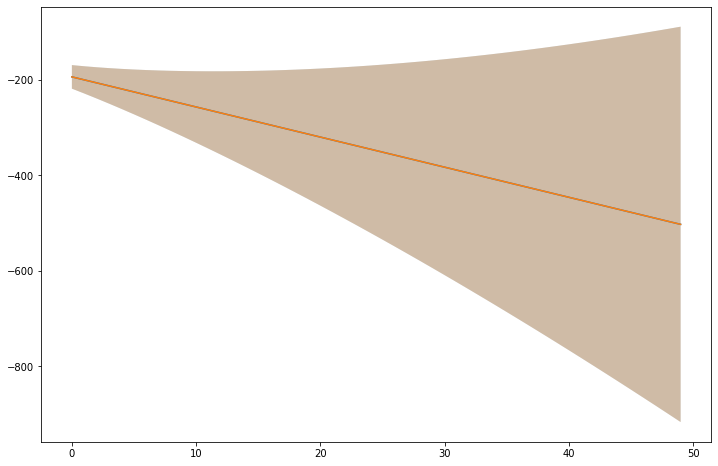

In [3]:
def _build_models(time_steps, key):
    
    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate parameters of the STS component
    level_scale = 5
    slope_scale = 0.5
    initial_level = standard_mvn.sample(seed=keys[0])
    initial_slope = standard_mvn.sample(seed=keys[1])

    obs_noise_scale = 10

    # Generate observed time series using the SSM representation.
    F = jnp.array([[1, 1],
                   [0, 1]])
    H = jnp.array([[1, 0]])
    Q = jnp.block([[level_scale, 0],
                   [0, slope_scale]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
        next_state = F @ current_state + Q @ MVN(jnp.zeros(2), jnp.eye(2)).sample(seed=key2)
        return next_state, current_obs

    initial_state = jnp.concatenate((initial_level, initial_slope))
    key_seq = jr.split(keys[2], time_steps)
    _, obs_time_series = lax.scan(_step, initial_state, key_seq)

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.LocalLinearTrend(observed_time_series=obs_time_series, name='local_linear_trend')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series)

    # Build the dynamax STS model.
    dynamax_comp = LocalLinearTrend(name='local_linear_trend')
    dynamax_model = STS([dynamax_comp], obs_time_series=obs_time_series)

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists, _ = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['local_linear_trend']['cov_level'] =\
        jnp.atleast_2d(jnp.array(tfp_params['local_linear_trend/_level_scale']**2))
    dynamax_model.params['local_linear_trend']['cov_slope'] =\
        jnp.atleast_2d(jnp.array(tfp_params['local_linear_trend/_slope_scale']**2))
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            obs_time_series,
            vi_dists)


time_steps=150
key=jr.PRNGKey(3)
    
tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
    _build_models(time_steps, key)

# Fit and forecast with the tfp module.
# Not use tfp.sts.decmopose_by_component() since its output series is centered at 0.
masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                              is_missing=tf.math.is_nan(obs_time_series))
tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                              include_observation_noise=False)
tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

# Fit and forecast with dynamax
dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                         obs_time_series)
dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                          num_forecast_steps=50)
dynamax_posterior_mean = dynamax_posterior['local_linear_trend']['pos_mean'].squeeze()
dynamax_posterior_cov = dynamax_posterior['local_linear_trend']['pos_cov'].squeeze()
dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

# Compare posterior inference by tfp and dynamax.
# In comparing the smoothed posterior, we omit the first 5 time steps,
# since the tfp and the dynamax implementations of STS has different settings in
# distributions of initial state, which will influence the posterior inference of
# the first few states.
len_step = jnp.abs(tfp_posterior_mean[1:]-tfp_posterior_mean[:-1]).mean()
assert jnp.allclose(tfp_posterior_mean[5:], dynamax_posterior_mean[5:], atol=len_step)
assert jnp.allclose(tfp_posterior_scale[5:], jnp.sqrt(dynamax_posterior_cov)[5:], rtol=1e-1)
# Compoare forecast by tfp and dynamax.
assert jnp.allclose(tfp_forecast_mean, dynamax_forecast_mean, atol=0.5*len_step)
assert jnp.allclose(tfp_forecast_scale, jnp.sqrt(dynamax_forecast_cov), rtol=5e-2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_posterior_mean)
ax.plot(dynamax_posterior_mean)
ax.fill_between(jnp.arange(150),
                 tfp_posterior_mean-2*tfp_posterior_scale,
                 tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(150),
                 dynamax_posterior_mean-2*jnp.sqrt(dynamax_posterior_cov),
                 dynamax_posterior_mean+2*jnp.sqrt(dynamax_posterior_cov),
                 alpha=0.3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_forecast_mean)
ax.plot(dynamax_forecast_mean)
ax.fill_between(jnp.arange(50),
                 tfp_forecast_mean-2*tfp_forecast_scale,
                 tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(50),
                 dynamax_forecast_mean-2*jnp.sqrt(dynamax_forecast_cov),
                 dynamax_forecast_mean+2*jnp.sqrt(dynamax_forecast_cov),
                 alpha=0.3)


Test SeasonalDummy forecast.

In [4]:
def _build_models(time_steps, key):

    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate parameters of the STS component
    num_seasons = 5
    drift_scale = 0.2
    obs_noise_scale = 1.

    # Generate observed time series using the SSM representation.
    # num_seasons = 5, so dim_of_state = 4.
    F = jnp.array([[-1, -1, -1, -1],
                   [ 1,  0,  0,  0],
                   [ 0,  1,  0,  0],
                   [ 0,  0,  1,  0]])

    H = jnp.array([[1, 0, 0, 0]])

    Q = drift_scale * jnp.array([[1, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
        next_state = F @ current_state + Q @ MVN(jnp.zeros(4), jnp.eye(4)).sample(seed=key2)
        return next_state, current_obs

    initial_state = jnp.array([8., 4., 0., -4.])
    key_seq = jr.split(keys[2], time_steps)
    _, obs_time_series = lax.scan(_step, initial_state, key_seq)

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.Seasonal(num_seasons, observed_time_series=obs_time_series,
                                name='seasonal_dummy')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series)

    # Build the dynamax STS model.
    dynamax_comp = SeasonalDummy(num_seasons, name='seasonal_dummy')
    dynamax_model = STS([dynamax_comp], obs_time_series=obs_time_series)

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists, _ = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['seasonal_dummy']['drift_cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['seasonal_dummy/_drift_scale']**2))
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            obs_time_series,
            vi_dists)


def test_seasonal_dummy_forecast(time_steps=150, key=jr.PRNGKey(3)):

    tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
        _build_models(time_steps, key)

    # Fit and forecast with the tfp module.
    # Not use tfp.sts.decmopose_by_component() since its output series is centered at 0.
    masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                                  is_missing=tf.math.is_nan(obs_time_series))
    tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                                  include_observation_noise=False)
    tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                     parameter_samples=tfp_params,
                                     num_steps_forecast=50,
                                     include_observation_noise=True)
    tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
    tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
    tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
    tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

    # Fit and forecast with dynamax
    dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                             obs_time_series)
    dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                              num_forecast_steps=50)
    dynamax_posterior_mean = dynamax_posterior['seasonal_dummy']['pos_mean'].squeeze()
    dynamax_posterior_cov = dynamax_posterior['seasonal_dummy']['pos_cov'].squeeze()
    dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
    dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

    # Compare posterior inference by tfp and dynamax.
    # In comparing the smoothed posterior, we omit the first 5 time steps,
    # since the tfp and the dynamax implementations of STS has different settings in
    # distributions of initial state, which will influence the posterior inference of
    # the first few states.
    len_step = jnp.abs(tfp_posterior_mean[1:]-tfp_posterior_mean[:-1]).mean()
    assert jnp.allclose(tfp_posterior_mean[5:], dynamax_posterior_mean[5:], atol=0.2*len_step)
    assert jnp.allclose(tfp_posterior_scale[5:], jnp.sqrt(dynamax_posterior_cov)[5:], rtol=3e-1)
    # Compoare forecast by tfp and dynamax.
    assert jnp.allclose(tfp_forecast_mean, dynamax_forecast_mean, atol=0.1*len_step)
    assert jnp.allclose(jnp.sqrt(dynamax_forecast_cov), tfp_forecast_scale, rtol=3e-1)

In [5]:
time_steps=150
key=jr.PRNGKey(2)

tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
        _build_models(time_steps, key)

# Fit and forecast with the tfp module.
# Not use tfp.sts.decmopose_by_component() since its output series is centered at 0.
masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                              is_missing=tf.math.is_nan(obs_time_series))
tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                              include_observation_noise=False)
tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

# Fit and forecast with dynamax
dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                         obs_time_series)
dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                          num_forecast_steps=50)
dynamax_posterior_mean = dynamax_posterior['seasonal_dummy']['pos_mean'].squeeze()
dynamax_posterior_cov = dynamax_posterior['seasonal_dummy']['pos_cov'].squeeze()
dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

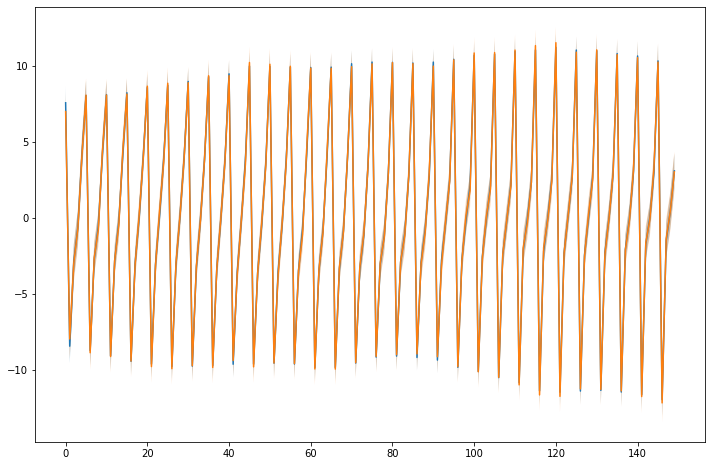

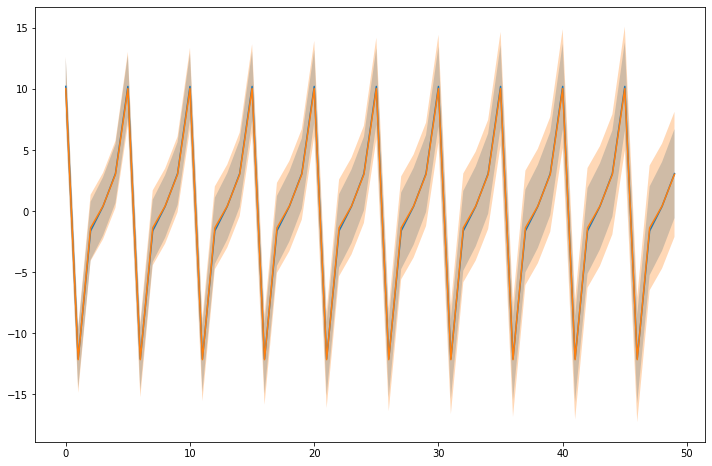

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_posterior_mean)
ax.plot(dynamax_posterior_mean)
ax.fill_between(jnp.arange(150),
                 tfp_posterior_mean-2*tfp_posterior_scale,
                 tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(150),
                 dynamax_posterior_mean-2*jnp.sqrt(dynamax_posterior_cov),
                 dynamax_posterior_mean+2*jnp.sqrt(dynamax_posterior_cov),
                 alpha=0.3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_forecast_mean)
ax.plot(dynamax_forecast_mean)
ax.fill_between(jnp.arange(50),
                 tfp_forecast_mean-2*tfp_forecast_scale,
                 tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(50),
                 dynamax_forecast_mean-2*jnp.sqrt(dynamax_forecast_cov),
                 dynamax_forecast_mean+2*jnp.sqrt(dynamax_forecast_cov),
                 alpha=0.3)

Test SeasonalTrig component

In [12]:
keys = jr.split(key, 5)
standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

# Generate parameters of the STS component
num_seasons = 5
drift_scale = 0.2
obs_noise_scale = 2.

# Generate observed time series using the SSM representation.
# num_seasons = 5, so dim_of_state = 4.
cos = lambda j: jnp.cos(2*jnp.pi*j/jnp.floor(num_seasons/2))
sin = lambda j: jnp.sin(2*jnp.pi*j/jnp.floor(num_seasons/2))

F = jnp.array([[ cos(1), sin(1),     0,      0],
               [-sin(1), cos(1),     0,      0],
               [     0,      0,  cos(2), sin(2)],
               [     0,      0, -sin(2), cos(2)]])

H = jnp.array([[1, 0, 1, 0]])

Q = drift_scale * jnp.eye(num_seasons-1)
R = obs_noise_scale

def _step(current_state, key):
    key1, key2 = jr.split(key)
    current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
    next_state = F @ current_state + Q @ MVN(jnp.zeros(4), jnp.eye(4)).sample(seed=key2)
    return next_state, (H @ current_state, current_obs)

initial_state = jnp.array([8., 4., 0., -4.])
key_seq = jr.split(keys[2], time_steps)
_, (obs_mean, obs_time_series) = lax.scan(_step, initial_state, key_seq)

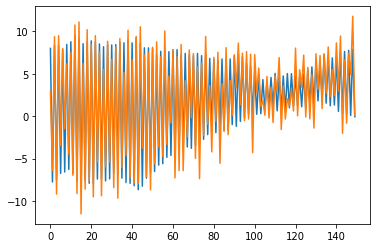

In [13]:
plt.plot(obs_mean)
plt.plot(obs_time_series)